# Read in data and compute rd_filters

In [1]:
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import pairwise_distances, pairwise_distances_argmin
import pandas as pd
import numpy as np

import sys
sys.path.insert(0, './rd_filters/') #https://github.com/PatWalters/rd_filters
from rd_filters import *

top_enamine_clustering = pd.read_csv('./enamine_costs_clustered_v3_with_nneighbor.csv.gz')

alert_file_name = './rd_filters/data/alert_collection.csv'
rules_file_name = './rd_filters/data/rules.json'
rf = RDFilters(alert_file_name)
rules_file_path = get_config_file(rules_file_name, "FILTER_RULES_DATA")
rule_dict = read_rules(rules_file_path)
rule_list = [x.replace("Rule_", "") for x in rule_dict.keys() if x.startswith("Rule") and rule_dict[x]]
rule_str = " and ".join(rule_list)
print(f"Using alerts from {rule_str}")
rf.build_rule_list(rule_list)

input_data = top_enamine_clustering[["rdkit SMILES", "idnumber"]].values.tolist()

start_time = time.time()
p = Pool(1)
filter_res = list(p.map(rf.evaluate, input_data))
rd_df = pd.DataFrame(filter_res, columns=["SMILES", "idnumber", "RD_FILTER", "MW", "LogP", "HBD", "HBA", "TPSA"])
filter_binary = np.zeros((rd_df.shape[0],), dtype='uint8')
for index, row in rd_df.iterrows():
    if row['RD_FILTER'] == "OK":
        filter_binary[index] = 1
rd_df["RD_FILTER"] = filter_binary
rd_df = rd_df[["idnumber", "RD_FILTER", "LogP"]]

top_enamine_clustering = top_enamine_clustering.merge(rd_df, on='idnumber')
# aggregate costs for 1-50
top_enamine_clustering['Price'] = top_enamine_clustering[['Price for 11-50 cmpds', 'Price for 40-49 cmpds']].sum(axis=1).values

Using alerts from Inpharmatica


In [2]:
des_cols = ['ID Enamine', 
            'REAL SMILES', 'rdkit SMILES', 'PAINS Filter', 
               'TB_0.4 ID', 'Hit', 'Is Train cluster?',
               'Is Train active cluster?', 'Is AMS cluster?',
               'Is AMS active cluster?', 'rf_preds',
               'Price', 'Status', 'Delivery term, weeks',
               'Closest Train Active ID', 'Closest Train Active TanDist',
               'Closest AMS Active ID', 'Closest AMS Active TanDist', '1024 MorganFP Radius 2',
               "RD_FILTER", "MW", "LogP", "HBD", "HBA", "TPSA", "Index ID"]
df = top_enamine_clustering[des_cols].sort_values('rf_preds', ascending=False)
df['rf_rank'] = df['rf_preds'].rank(method='first', ascending=False)
df = df[des_cols[:-1] + ['rf_rank', 'Index ID']]

---
# Apply filters

In [3]:
print('Shape: {}'.format(df.shape[0]))
# get cpds in clusters that don't exist in train or ams ACTIVE clusters
prune_df1 = df[(df['Is Train active cluster?'] == 0) & (df['Is AMS active cluster?'] == 0)]
failed_df1 = df[~df['ID Enamine'].isin(prune_df1['ID Enamine'])]
print('1. Shape: {}'.format(prune_df1.shape[0]))

# pass PAINS and RD_FILTERS filter
prune_df2 = prune_df1[(prune_df1['PAINS Filter'] == 1) * (prune_df1['RD_FILTER'] == 1)]
failed_df2 = prune_df1[~prune_df1['ID Enamine'].isin(prune_df2['ID Enamine'])]
print('2. Shape: {}'.format(prune_df2.shape[0]))

# take only cpds that are from from tain and ams actives
tandist_thresh=0.35
prune_df3 = prune_df2[(prune_df2['Closest Train Active TanDist'] >= tandist_thresh) & (prune_df2['Closest AMS Active TanDist'] >= tandist_thresh)]
failed_df3 = prune_df2[~prune_df2['ID Enamine'].isin(prune_df3['ID Enamine'])]
print('3. Shape: {}'.format(prune_df3.shape[0]))

# get highest prediction from each cluster
prune_df4 = prune_df3.drop_duplicates(subset='TB_0.4 ID', keep='first').reset_index(drop=True)
failed_df4 = prune_df3[~prune_df3['ID Enamine'].isin(prune_df4['ID Enamine'])]
print('4. Shape: {}'.format(prune_df4.shape[0]))

Shape: 5620
1. Shape: 2679
2. Shape: 1604
3. Shape: 1354
4. Shape: 311


---
# Select 100 diverse from the remaining

In [4]:
num_cpds = 100
cpds_to_select = [0] # first select cpd with highest rf_rank

X_prosp = np.vstack([np.fromstring(x, 'u1') - ord('0') for x in prune_df4['1024 MorganFP Radius 2']]).astype(float)
for i in range(1, 100):
    x = X_prosp[cpds_to_select,:]
    remaining_cpds = np.setdiff1d(np.arange(X_prosp.shape[0]), cpds_to_select)
    y = X_prosp[remaining_cpds,:]
    tandist = pairwise_distances(y, x, metric='jaccard')
    farthest_idx = np.argmax(tandist.mean(axis=1)); 
    
    cpds_to_select.append(remaining_cpds[farthest_idx])
    
final_list = prune_df4.iloc[cpds_to_select,:]
final_list = final_list.sort_values('rf_preds', ascending=False)

In [5]:
final_list.to_csv('./enamine_final_list.csv.gz', index=False)

In [6]:
final_list[['MW','LogP','HBD','HBA','TPSA']].describe().loc[['min', 'max']]

,MW,LogP,HBD,HBA,TPSA
min,145.165,-0.4808,0.0,1.0,3.24
max,478.983,4.9978,4.0,8.0,127.56


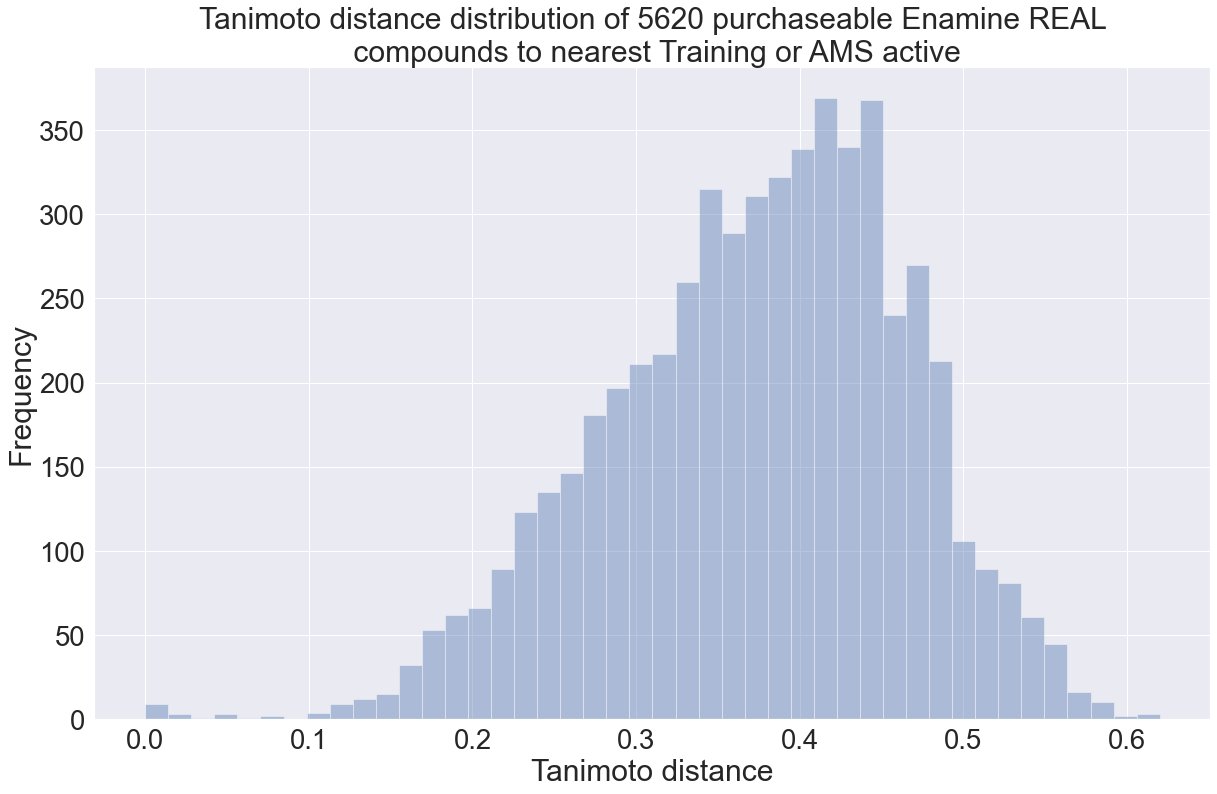

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_context("paper");sns.set(font_scale=2.5);figsize=(20, 12)

tan_dist = top_enamine_clustering[['Closest Train Active TanDist', 'Closest AMS Active TanDist']].min(axis=1).values
bin_range= [0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65] #np.linspace(0.35, 0.65, 10)
plt.figure(figsize=figsize)

sns.distplot(tan_dist, norm_hist=False, kde=False)  
plt.title('Tanimoto distance distribution of 5620 purchaseable Enamine REAL\n compounds to nearest Training or AMS active')
plt.xlabel('Tanimoto distance'); plt.ylabel('Frequency');
plt.show()